In [47]:
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import arviz as az
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.rcParams["figure.figsize"] = (15, 10)

In [161]:
x = np.linspace(0, 100, 100)
y = np.sqrt(x) + np.sin(x) + np.random.randn(len(x))

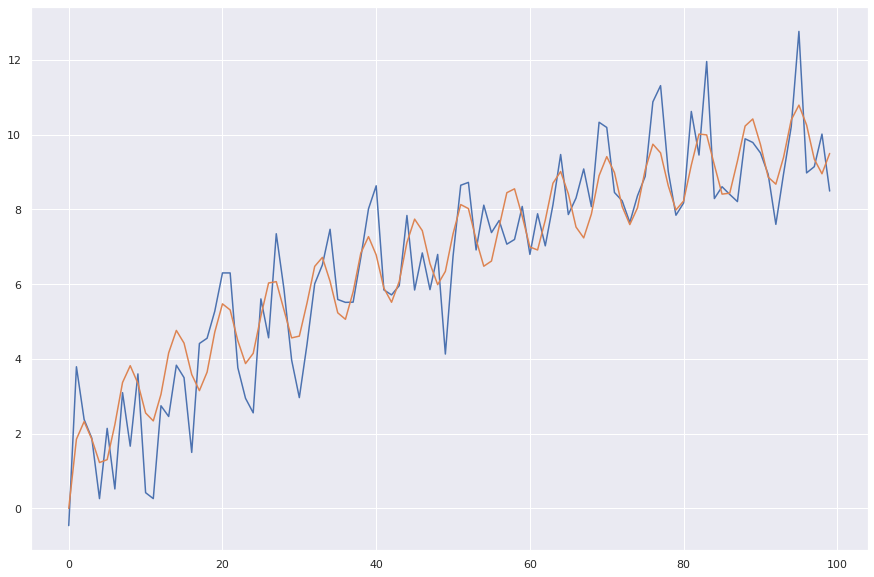

In [162]:
plt.plot(y)
plt.plot(np.sqrt(x) + np.sin(x))

In [195]:
def exp_quad_cov(alpha, rho, x):
    sq_dist = np.square(x[None, :] - x[:, None])
    return alpha**2 * np.exp((-1/2*rho**2) * sq_dist)

In [252]:
test = stats.multivariate_normal.rvs(mean=np.zeros(len(x)), cov=exp_quad_cov(1, 0.1, x), size=5)

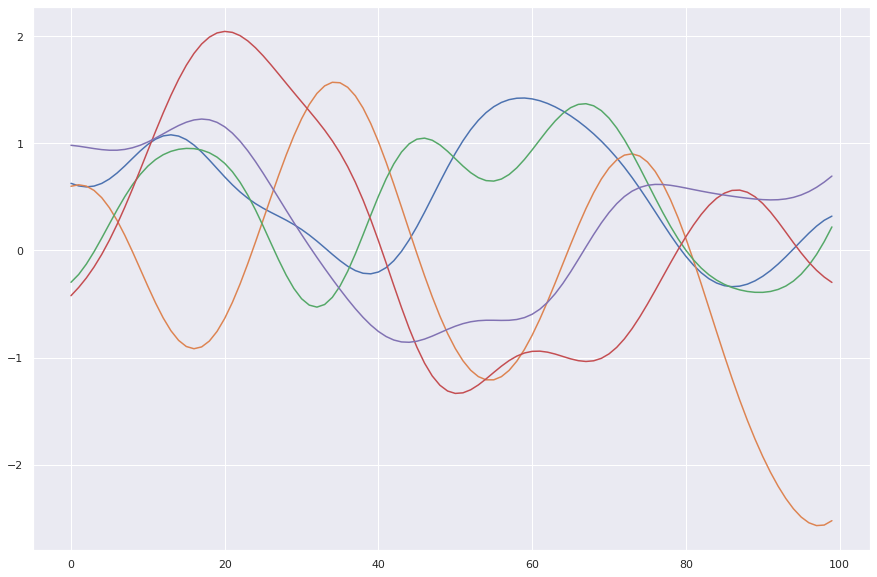

In [253]:
plt.plot(test.T)

In [115]:
model_spec = """
data {
    int<lower=1> N;
    array[N] real x;
    vector[N] y;
}
transformed data {
    real delta = 1e-9;
}
parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    real<lower=0> sigma;
    vector[N] eta;
}
transformed parameters {
    vector[N] f;
    {
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);

        // diagonal elements
        for (n in 1:N) {
            K[n, n] = K[n, n] + delta;
        }

        L_K = cholesky_decompose(K);
        f = L_K * eta;
    }
}
model {
    rho ~ inv_gamma(5, 5);
    alpha ~ std_normal();
    sigma ~ std_normal();
    eta ~ std_normal();

    y ~ normal(f, sigma);
}
generated quantities {
    real y_tilde[N];
    y_tilde = normal_rng(f, sigma);
}
"""

In [116]:
import os
os.chdir("/home/eadains/VolatilityTrading")

In [117]:
with open("./stan_model/RV_model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/RV_model.stan")
data = {
    "N": len(x),
    "y": y,
    "x": x
}
sample = model.sample(
    data=data, chains=4, parallel_chains=4, iter_warmup=250, iter_sampling=250
)


INFO:cmdstanpy:compiling stan file /home/eadains/VolatilityTrading/stan_model/RV_model.stan to exe file /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:compiled model executable: /home/eadains/VolatilityTrading/stan_model/RV_model
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/eadains/VolatilityTrading/stan_model/RV_model.hpp /home/eadains/VolatilityTrading/stan_model/RV_model.stan
Warning in '/home/eadains/VolatilityTrading/stan_model/RV_model.stan', line 20, column 25: cov_exp_quad is deprecated and will be removed in the future. Use gp_exp_quad_cov instead.

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_D

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [122]:
model_data = az.from_cmdstanpy(
    posterior=sample, observed_data={"y": y}, posterior_predictive="y_tilde"
)

array([[<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

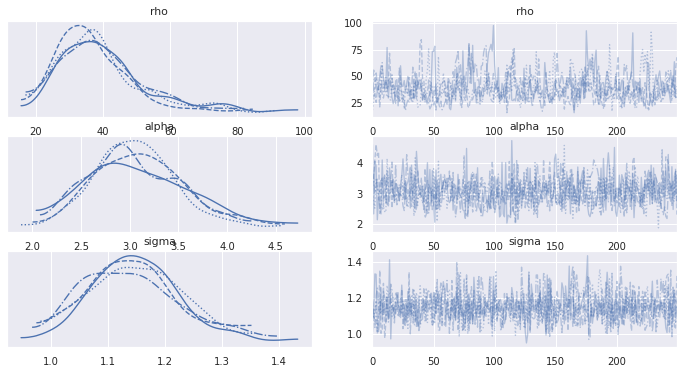

In [123]:
az.plot_trace(model_data, compact=True, var_names=["rho", "alpha", "sigma"])

Text(0.5, 1.0, 'Kurtosis')

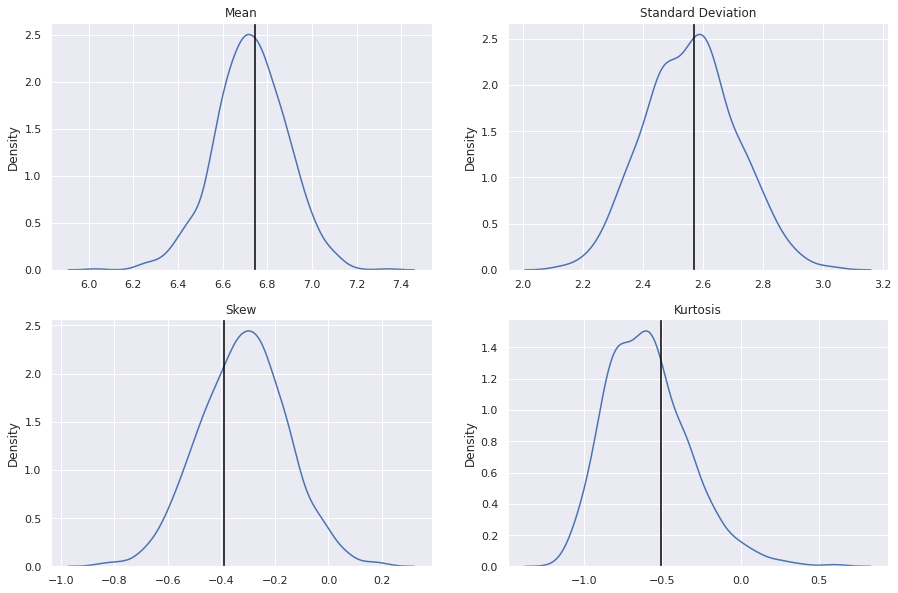

In [124]:
y_tilde = model_data.posterior_predictive.y_tilde.values.reshape(1000, -1)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

fig, axs = plt.subplots(2, 2)
sns.kdeplot(mean, ax=axs[0, 0])
axs[0, 0].axvline(np.mean(model_data.observed_data.y.values), color="black")
axs[0, 0].set_title("Mean")
sns.kdeplot(std, ax=axs[0, 1])
axs[0, 1].axvline(np.std(model_data.observed_data.y.values), color="black")
axs[0, 1].set_title("Standard Deviation")
sns.kdeplot(skew, ax=axs[1, 0])
axs[1, 0].axvline(stats.skew(model_data.observed_data.y.values), color="black")
axs[1, 0].set_title("Skew")
sns.kdeplot(kurt, ax=axs[1, 1])
axs[1, 1].axvline(stats.kurtosis(model_data.observed_data.y.values), color="black")
axs[1, 1].set_title("Kurtosis")

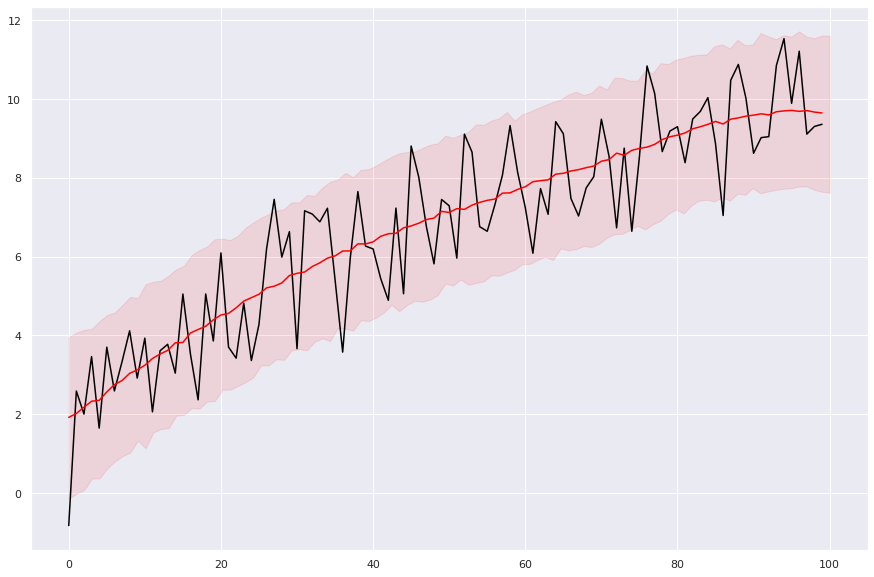

In [125]:
plt.plot(y, color="black")
plt.plot(np.mean(y_tilde, axis=0), color="red")
plt.fill_between(x, np.percentile(y_tilde, 95, axis=0), np.percentile(y_tilde, 5, axis=0), color="red", alpha=0.1)